In [1]:
import os
import math
from glob import glob
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
observations = pd.read_csv('data/n100_final_data.csv', parse_dates=['date'])
covariates = pd.read_csv('data/covariates.csv', parse_dates=['date'])

stations = ['SGP', 'EGB', 'AMA', 'SAO', 'HRW', 'VIE', 'BSL', 'WAL', 'POV', 'MLP', 'ABZ',
            'ABZ', 'NEU', 'VHL', 'KCE', 'ASP', 'KPZ', 'PRL', 'HYY', 'HEL', 'VAR', 'BOT',
            'MAR', 'AMM', 'HAD', 'UAE', 'DEL', 'MUK', 'ZOT', 'BEI', 'NAN']

observations = observations[observations.station.isin(stations)]
observations = observations.sort_values(by=['station', 'date'])
covariates = covariates[covariates.station.isin(stations)]

observations.reset_index(inplace=True, drop=True)
covariates.reset_index(inplace=True, drop=True)

aerosols = ['aermr01', 'aermr02', 'aermr03', 'aermr04', 'aermr05', 'aermr06', 
            'aermr07', 'aermr08', 'aermr09', 'aermr10', 'aermr11']

gases = ['co', 'c5h8', 'c10h16', 'nh3', 'no', 'no2', 'so2']

met = ['d2m', 't2m', 'blh', 'rh', 'wind_speed', 'crwc']
        
loc = ['latitude', 'longitude']

feature_list = gases + met + aerosols + loc

log_transform = aerosols + gases + ['crwc']

# log-transforming the selected variables, setting negative values to the minimum observed positive value
for v in log_transform:
    covariates[v] = np.log(covariates[v].where(covariates[v] > 0, covariates[v][covariates[v] > 0].min()))

In [3]:
observations.head()

,date,station,n100,interpolated
0,2012-01-26 17:30:00,ABZ,2967.4,False
1,2012-01-26 18:29:00,ABZ,2756.7,False
2,2012-01-26 19:30:00,ABZ,3260.1,False
3,2012-01-26 20:30:00,ABZ,3013.8,False
4,2012-01-26 21:29:00,ABZ,2525.4,False


In [4]:
covariates.head()

,station,date,latitude,longitude,aermr01,aermr02,aermr03,aermr04,aermr05,aermr06,...,nh3,no,no2,so2,d2m,t2m,crwc,blh,rh,wind_speed
0,ABZ,2012-01-01 00:00:00,50.57,12.99,-25.355977,-20.909174,-22.343819,-28.333114,-27.757818,-38.593041,...,-21.426934,-21.786924,-17.896776,-19.201569,274.34976,274.74243,-14.221623,226.21110,97.224089,2.388552
1,ABZ,2012-01-01 03:00:00,50.57,12.99,-25.189441,-20.742743,-21.742577,-27.741422,-27.222011,-38.593041,...,-21.477355,-21.303943,-17.804649,-19.415708,275.56702,275.84317,-13.510900,227.60513,98.057947,2.525840
2,ABZ,2012-01-01 06:00:00,50.57,12.99,-24.923867,-20.477188,-21.259371,-27.626435,-27.201714,-38.593041,...,-21.661976,-21.043660,-17.830820,-20.349518,276.51514,276.86853,-12.646381,296.77762,97.541081,2.777447
3,ABZ,2012-01-01 09:00:00,50.57,12.99,-25.046023,-20.600007,-21.084985,-28.082914,-27.757033,-38.593041,...,-21.716530,-20.625583,-18.118168,-20.523233,277.77420,278.42493,-15.837863,641.16990,95.568645,3.490278
4,ABZ,2012-01-01 12:00:00,50.57,12.99,-25.559982,-21.119738,-21.752305,-28.977890,-28.543334,-29.189096,...,-21.213817,-20.988900,-18.565042,-20.211755,279.82742,280.83896,-14.807189,586.82715,93.313550,3.836724


In [5]:
observations = observations.dropna(axis=0)
observations.reset_index(inplace=True, drop=True)

In [6]:
# calculate time difference between consecutive rows
observations['time_diff'] = observations.groupby('station')['date'].diff()

# calculate mode time difference for each station
mode_diff = observations.groupby('station')['time_diff'].apply(lambda x: x.mode().iloc[0])

# function to find rows where time difference is greater than mode time difference
def find_gaps(group):
    station = group.name
    return group['time_diff'] > pd.Timedelta(hours=1) + mode_diff[station]

gap_rows = observations.groupby('station').apply(find_gaps).reset_index(level=0, drop=True)

# create a new segment every time a gap is detected
segment_ids = gap_rows.groupby(observations['station']).cumsum()

# Reset the index on segment_ids
segment_ids = segment_ids.reset_index(level=0, drop=True)

# create group_ids column by concatenating station name and segment_ids
observations['group_ids'] = observations['station'] + '_segment_' + segment_ids.astype(str)

observations = observations[['date', 'n100', 'station', 'group_ids']]

In [7]:
observations.groupby('station')['group_ids'].nunique()

station
ABZ     634
AMA     123
AMM      27
ASP     108
BEI     142
BOT     113
BSL      27
DEL      86
EGB      28
HAD     102
HEL     149
HRW      74
HYY     248
KCE     306
KPZ     196
MAR     105
MLP     155
MUK     648
NAN      96
NEU      66
POV     311
PRL      52
SAO      47
SGP    1496
UAE      34
VAR     338
VHL      32
VIE      52
WAL      82
ZOT      18
Name: group_ids, dtype: int64

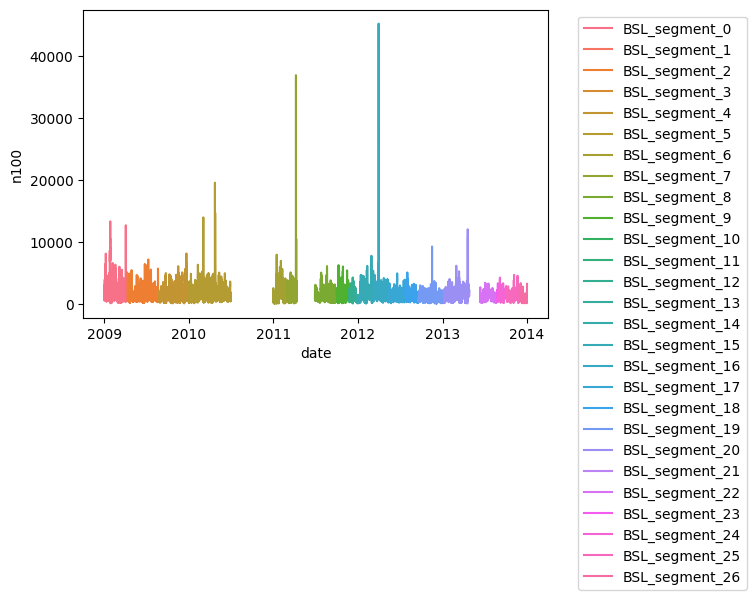

In [8]:
# Filter the data for station ZOT
filtered_data = observations[observations.station == 'BSL']

# Create the plot
plt.figure(figsize=(6, 4))
sns.lineplot(data=filtered_data, x='date', y='n100', hue='group_ids')

# Place the legend to the right of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [9]:
# group by station and group_ids, and calculate the time span of each segment in hours
segment_lengths = observations.groupby(['station', 'group_ids'])['date'].apply(lambda x: (x.max() - x.min()).total_seconds() / 3600)

# calculate time difference between consecutive rows
time_diff = observations.groupby('station')['date'].diff()

# filter for rows where time difference is greater than 3 hours
gap_lengths = time_diff[time_diff > pd.Timedelta(hours=1, minutes=5)]

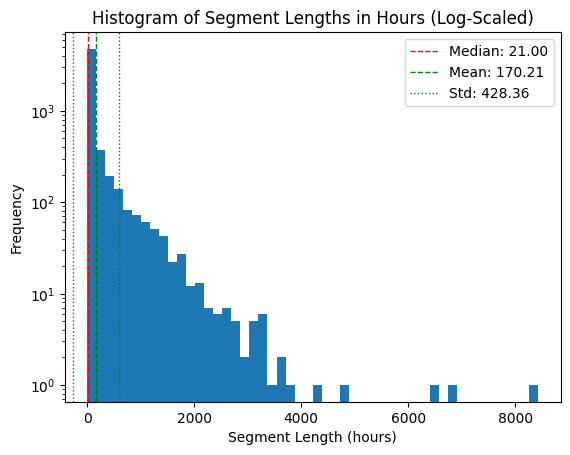

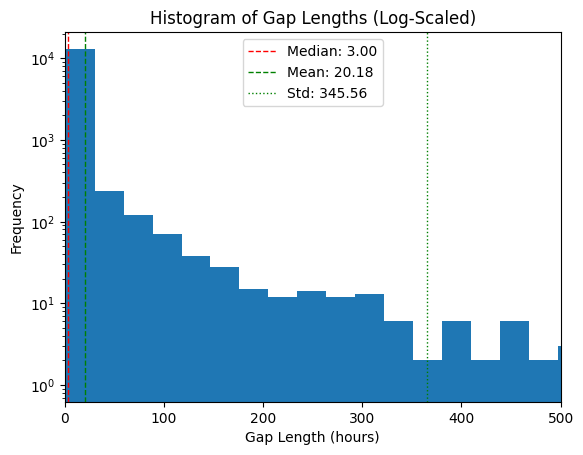

In [10]:
# calculate median, mean, and std for segment lengths in hours
segment_median = np.median(segment_lengths)
segment_mean = np.mean(segment_lengths)
segment_std = np.std(segment_lengths)

# create histogram of segment lengths with median, mean, and std plotted
plt.hist(segment_lengths, bins=50, log=True)
plt.xlabel('Segment Length (hours)')
plt.ylabel('Frequency')
plt.title('Histogram of Segment Lengths in Hours (Log-Scaled)')
plt.axvline(segment_median, color='r', linestyle='dashed', linewidth=1)
plt.axvline(segment_mean, color='g', linestyle='dashed', linewidth=1)
plt.axvline(segment_mean + segment_std, color='g', linestyle='dotted', linewidth=1)
plt.axvline(segment_mean - segment_std, color='g', linestyle='dotted', linewidth=1)
plt.legend(['Median: {:.2f}'.format(segment_median), 'Mean: {:.2f}'.format(segment_mean), 'Std: {:.2f}'.format(segment_std)])
plt.show()
# calculate median, mean, and std for gap lengths
gap_median = np.median(gap_lengths / pd.Timedelta(hours=1))
gap_mean = np.mean(gap_lengths / pd.Timedelta(hours=1))
gap_std = np.std(gap_lengths / pd.Timedelta(hours=1))

# create histogram of gap lengths with median, mean, and std plotted
plt.hist(gap_lengths / pd.Timedelta(hours=1), bins=1000, log=True)
plt.xlabel('Gap Length (hours)')
plt.ylabel('Frequency')
plt.title('Histogram of Gap Lengths (Log-Scaled)')
plt.axvline(gap_median, color='r', linestyle='dashed', linewidth=1)
plt.axvline(gap_mean, color='g', linestyle='dashed', linewidth=1)
plt.axvline(gap_mean + gap_std, color='g', linestyle='dotted', linewidth=1)
plt.axvline(gap_mean - gap_std, color='g', linestyle='dotted', linewidth=1)
plt.legend(['Median: {:.2f}'.format(gap_median), 'Mean: {:.2f}'.format(gap_mean), 'Std: {:.2f}'.format(gap_std)])
plt.xlim([0, 500])
plt.show()

In [11]:
# group by station and group_ids, and calculate the time span of each segment in hours
segment_lengths = observations.groupby(['station', 'group_ids'])['date'].apply(lambda x: (x.max() - x.min()).total_seconds() / 3600)

In [12]:
# total number of segments
total_segments = len(segment_lengths)
print(f"Total number of segments: {total_segments}")

# count the number of segments longer than each 24-hour increment up to 240 hours
for i in range(24, 24*11, 24):
    num_segments_longer_than_i = sum(segment_lengths > i)
    print(f"Number of segments longer than {i} hours: {num_segments_longer_than_i}")

Total number of segments: 5895
Number of segments longer than 24 hours: 2445
Number of segments longer than 48 hours: 2033
Number of segments longer than 72 hours: 1741
Number of segments longer than 96 hours: 1541
Number of segments longer than 120 hours: 1393
Number of segments longer than 144 hours: 1274
Number of segments longer than 168 hours: 1137
Number of segments longer than 192 hours: 1055
Number of segments longer than 216 hours: 1007
Number of segments longer than 240 hours: 950


In [40]:
covariates[covariates.station == 'POV'].set_index('date')

,station,latitude,longitude,aermr01,aermr02,aermr03,aermr04,aermr05,aermr06,aermr07,...,nh3,no,no2,so2,d2m,t2m,crwc,blh,rh,wind_speed
date,,,,,,,,,,,,,,,,,,,,,
2003-01-01 00:00:00,POV,44.65,11.62,-25.455960,-21.027784,-20.838464,-27.185314,-26.712700,-27.061414,-17.564572,...,-19.880971,-17.051370,-17.289416,-18.284766,279.35760,281.36646,-11.592964,298.519530,87.161555,2.282003
2003-01-01 03:00:00,POV,44.65,11.62,-25.759631,-21.327513,-20.623852,-27.359864,-27.014581,-27.654692,-17.305397,...,-19.846501,-16.762752,-17.273640,-18.158133,278.52905,279.98890,-17.367779,154.353790,90.416836,1.623495
2003-01-01 06:00:00,POV,44.65,11.62,-26.080369,-21.645721,-20.725661,-27.590640,-27.390136,-28.268498,-17.125231,...,-20.308545,-16.500221,-17.371635,-18.526429,278.73425,280.63446,-17.007148,80.822296,87.749701,0.959207
2003-01-01 09:00:00,POV,44.65,11.62,-25.942517,-21.505339,-20.494374,-27.696178,-27.529087,-28.233324,-17.065974,...,-21.019037,-16.393353,-17.568227,-19.114000,278.79605,280.58313,-16.339500,126.598890,88.435549,0.576271
2003-01-01 12:00:00,POV,44.65,11.62,-26.910087,-22.467312,-22.092905,-29.182486,-29.184063,-30.475963,-18.211752,...,-20.914400,-16.975275,-17.462550,-18.952014,279.29138,282.44724,-17.130053,374.594000,80.654575,0.715790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2006-12-31 09:00:00,POV,44.65,11.62,-27.088630,-22.654090,-23.333241,-25.913096,-25.200200,-24.193584,-17.367837,...,-21.465238,-16.496401,-18.066987,-19.923639,275.55360,277.32250,-17.209162,100.771910,88.260404,1.400922
2006-12-31 12:00:00,POV,44.65,11.62,-25.957318,-21.519736,-23.164506,-24.765208,-23.942170,-23.127682,-17.672556,...,-21.471953,-17.267655,-17.643436,-20.015658,277.99377,280.43692,-16.120385,249.641980,84.479961,1.769186
2006-12-31 15:00:00,POV,44.65,11.62,-25.998572,-21.559977,-23.201332,-24.168569,-23.363130,-22.881556,-17.721802,...,-20.723339,-17.489702,-17.660390,-19.627921,278.52637,281.45898,-18.461465,107.973130,81.775800,1.370016


In [41]:
observations[observations.group_ids == 'POV_segment_15']

,date,n100,station,group_ids
2870678,2003-01-18 12:00:00,7290.0,POV,POV_segment_15
2870679,2003-01-18 15:00:00,7580.0,POV,POV_segment_15
2870680,2003-01-18 18:00:00,7620.0,POV,POV_segment_15
2870681,2003-01-18 21:00:00,7910.0,POV,POV_segment_15
2870682,2003-01-19 00:00:00,4670.0,POV,POV_segment_15
...,...,...,...,...
2870772,2003-01-30 06:00:00,7710.0,POV,POV_segment_15
2870773,2003-01-30 09:00:00,7170.0,POV,POV_segment_15
2870774,2003-01-30 12:00:00,5610.0,POV,POV_segment_15
2870775,2003-01-30 15:00:00,6930.0,POV,POV_segment_15


In [13]:
observations.head()

,date,n100,station,group_ids
0,2012-01-26 17:30:00,2967.4,ABZ,ABZ_segment_0
1,2012-01-26 18:29:00,2756.7,ABZ,ABZ_segment_0
2,2012-01-26 19:30:00,3260.1,ABZ,ABZ_segment_0
3,2012-01-26 20:30:00,3013.8,ABZ,ABZ_segment_0
4,2012-01-26 21:29:00,2525.4,ABZ,ABZ_segment_0


In [14]:
covariates.head()

,station,date,latitude,longitude,aermr01,aermr02,aermr03,aermr04,aermr05,aermr06,...,nh3,no,no2,so2,d2m,t2m,crwc,blh,rh,wind_speed
0,ABZ,2012-01-01 00:00:00,50.57,12.99,-25.355977,-20.909174,-22.343819,-28.333114,-27.757818,-38.593041,...,-21.426934,-21.786924,-17.896776,-19.201569,274.34976,274.74243,-14.221623,226.21110,97.224089,2.388552
1,ABZ,2012-01-01 03:00:00,50.57,12.99,-25.189441,-20.742743,-21.742577,-27.741422,-27.222011,-38.593041,...,-21.477355,-21.303943,-17.804649,-19.415708,275.56702,275.84317,-13.510900,227.60513,98.057947,2.525840
2,ABZ,2012-01-01 06:00:00,50.57,12.99,-24.923867,-20.477188,-21.259371,-27.626435,-27.201714,-38.593041,...,-21.661976,-21.043660,-17.830820,-20.349518,276.51514,276.86853,-12.646381,296.77762,97.541081,2.777447
3,ABZ,2012-01-01 09:00:00,50.57,12.99,-25.046023,-20.600007,-21.084985,-28.082914,-27.757033,-38.593041,...,-21.716530,-20.625583,-18.118168,-20.523233,277.77420,278.42493,-15.837863,641.16990,95.568645,3.490278
4,ABZ,2012-01-01 12:00:00,50.57,12.99,-25.559982,-21.119738,-21.752305,-28.977890,-28.543334,-29.189096,...,-21.213817,-20.988900,-18.565042,-20.211755,279.82742,280.83896,-14.807189,586.82715,93.313550,3.836724


In [34]:
# Define the sequence length
max_gap_size = 120 # 5 days
sequence_length = pd.Timedelta(hours=168) # 7 days
covariate_size = 60 # more than 168h / 3h
observation_size = 2030 # more than 168h / 5 minutes


def create_gaps(seq, gap_size):
    center = len(seq) // 2
    half_gap = gap_size // 2
    start = max(0, center - half_gap)
    end = min(len(seq), center + half_gap)
    mask = np.ones(len(seq), dtype=bool)
    mask[start:end] = False
    return mask

for group_id in tqdm(observations.group_ids.unique()):
    group_data = observations[observations.group_ids == group_id].copy()
    station = group_id.split('_')[0]
    
    # Exclude groups shorter than sequence_length
    if group_data['date'].max() - group_data['date'].min() < sequence_length:
        continue
    
    # Define the timedelta in terms of number of observations
    average_interval = group_data['date'].diff().mean()
    obs_per_hour = int(round(pd.Timedelta(hours=1) / average_interval))
    
    # Loop over sequences within the group
    start_date = group_data['date'].min()
    split_index = 0
    while start_date + sequence_length <= group_data['date'].max():
        split_data = group_data[(group_data['date'] >= start_date) & (group_data['date'] < start_date + sequence_length)].copy()
        start_date += sequence_length
        
        # For every split_data take covariates in +/- 3 hour range of min and max date
        station_covariates = covariates[covariates.station == station]
        covariate_data = station_covariates[
              (station_covariates['date'] >= (split_data.date.min() - pd.Timedelta(hours=3))) 
            & (station_covariates['date'] <= (split_data.date.max() + pd.Timedelta(hours=3)))]
        
        if covariate_data.size < 12:
            print(f'{group_id}_{split_index} lack covariates')
            split_index += 1
            continue
        
        # Create a gap with size randomly chosen between one hour and 120 hours (5 days)
        low = max(1, obs_per_hour)
        high = max_gap_size*obs_per_hour
        if low > high:
            print(f'{group_id}_{split_index} low > high gap size')
            split_index += 1
            continue
        gap_size = np.random.randint(low=low, high=high)
        split_data['mask'] = create_gaps(split_data['n100'], gap_size)
        
        # Interpolate 'n100' in the gap using time method
        split_data.set_index('date', inplace=True)
        split_data.loc[~split_data['mask'], 'n100'] = np.nan
        split_data['n100'] = split_data['n100'].interpolate(method='time')
        split_data.reset_index(inplace=True)
        split_data.rename(columns={'index': 'date'}, inplace=True)
        
        assert len(split_data) <= observation_size, f'split_data has {len(split_data)} rows before padding'
        
        # Pad observations
        split_data.loc[:, 'padded'] = False
        pad_size = max(0, observation_size - len(split_data))
        if pad_size > 0:
            last_row = split_data.tail(1)
            padding_df = pd.concat([last_row]*pad_size, ignore_index=True)
            padding_df.loc[:,'padded'] = True
            split_data = pd.concat([split_data, padding_df], ignore_index=True)
        
        # Pad covariates
        covariate_data.loc[:, 'padded'] = False
        pad_size = max(0, covariate_size - len(covariate_data))
        if pad_size > 0:
            last_row = covariate_data.tail(1)
            padding_df = pd.concat([last_row]*pad_size, ignore_index=True)
            padding_df.loc[:,'padded'] = True
            covariate_data = pd.concat([covariate_data, padding_df], ignore_index=True)
        
        # Save to file
        os.makedirs(f'granular_data/{group_id}_{split_index}', exist_ok=True)
        split_data.to_csv(f'granular_data/{group_id}_{split_index}/observations.csv', index=False)
        covariate_data.to_csv(f'granular_data/{group_id}_{split_index}/covariates.csv', index=False)
        
        # Increase the split_index by 1 for the next iteration
        split_index += 1

  0%|          | 0/5895 [00:00<?, ?it/s]

BEI_segment_51_0 lack covariates
BEI_segment_54_0 lack covariates
BEI_segment_89_0 lack covariates
BEI_segment_92_0 lack covariates
BEI_segment_92_1 lack covariates
BEI_segment_93_0 lack covariates
BEI_segment_95_0 lack covariates
BEI_segment_95_1 lack covariates
BEI_segment_95_2 lack covariates
BEI_segment_106_0 lack covariates
BEI_segment_136_0 lack covariates
BEI_segment_136_1 lack covariates
BEI_segment_138_0 lack covariates
BEI_segment_138_1 lack covariates
BEI_segment_138_2 lack covariates
BEI_segment_141_0 lack covariates
BEI_segment_141_1 lack covariates
EGB_segment_27_0 lack covariates
HEL_segment_148_4 lack covariates
HEL_segment_148_5 lack covariates
HEL_segment_148_6 lack covariates
MLP_segment_154_2 lack covariates
MUK_segment_515_0 lack covariates
MUK_segment_519_0 lack covariates
MUK_segment_521_0 lack covariates
MUK_segment_522_0 lack covariates
MUK_segment_523_0 lack covariates
MUK_segment_529_0 lack covariates
MUK_segment_581_0 lack covariates
MUK_segment_583_0 lack c

In [20]:
def check_nan_inf_in_csv(directory):
    for subdir, dirs, files in tqdm(os.walk(directory)):
        for file in files:
            if file.endswith('.csv'):
                file_path = os.path.join(subdir, file)
                df = pd.read_csv(file_path)

                if (len(df) != 60) and (len(df) != 2020):
                    print(file_path)

check_nan_inf_in_csv('granular_data/')

0it [00:00, ?it/s]

granular_data/AMA_segment_63_0/observations.csv


In [28]:
def check_nan_inf_in_csv(directory):
    for subdir, dirs, files in tqdm(os.walk(directory)):
        for file in files:
            if file.endswith('.csv'):
                file_path = os.path.join(subdir, file)
                df = pd.read_csv(file_path)

                # Select only numeric columns
                numeric_df = df.select_dtypes(include=[np.number])

                if numeric_df.isnull().values.any():  # Check for NaN
                    print(f"Found NaN in file: {file_path}")
                if np.isinf(numeric_df.values).any():  # Check for Inf
                    print(f"Found Inf in file: {file_path}")

check_nan_inf_in_csv('granular_data/')

0it [00:00, ?it/s]

Found NaN in file: granular_data/ASP_segment_67_3/.ipynb_checkpoints/observations-checkpoint.csv
Found NaN in file: granular_data/BSL_segment_20_8/observations.csv
Found NaN in file: granular_data/ASP_segment_26_0/observations.csv
Found NaN in file: granular_data/ASP_segment_100_2/observations.csv
Found NaN in file: granular_data/ASP_segment_55_1/.ipynb_checkpoints/observations-checkpoint.csv
